In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode,substring, length
from pyspark.sql.types import DecimalType, StringType
from pyspark.sql.types import DoubleType
from itertools import cycle

from pyspark.sql.functions import col, split, explode,substring, length, udf
from pyspark.sql.types import *
from pyspark.sql import Row
from itertools import cycle
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F
from pyspark.sql import types as T

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Setting up spark
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


print(spark)
print(spark.version)

3.0.0-preview2


In [4]:
topinves_df=spark.read.csv("hdfs://localhost:9000/eda/dc_investments.csv", header='true', inferSchema='true')

In [5]:
columns_to_drop = ['_c0', 'company_permalink','investor_permalink','funding_round_permalink']
topinves_df = topinves_df.drop(*columns_to_drop)

In [6]:
topinves_df.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- company_category_list: string (nullable = true)
 |-- company_country_code: string (nullable = true)
 |-- company_region: string (nullable = true)
 |-- company_city: string (nullable = true)
 |-- investor_name: string (nullable = true)
 |-- investor_country_code: string (nullable = true)
 |-- funding_round_type: string (nullable = true)
 |-- funded_at: string (nullable = true)
 |-- raised_amount_usd: double (nullable = true)



In [7]:
topinves_df.select('raised_amount_usd', 'funded_at','company_category_list').filter(topinves_df.company_category_list.contains('|')).show(5, truncate = False)

+-----------------+----------+----------------------------+
|raised_amount_usd|funded_at |company_category_list       |
+-----------------+----------+----------------------------+
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|6602693.89911084 |2015-11-04|Local Businesses|Restaurants|
|1736910.0        |2013-11-13|Local Businesses|Restaurants|
+-----------------+----------+----------------------------+
only showing top 5 rows



In [9]:
splitCategory = topinves_df.select('raised_amount_usd',  substring('funded_at',-0,4).cast('int').alias('year')
                       , split(col("company_category_list")
                       , "[|]s*").alias("category_list")).filter(col('year') >= 1990)
splitCategory.show(5)

+-----------------+----+-------------+
|raised_amount_usd|year|category_list|
+-----------------+----+-------------+
|        2000000.0|2008|[Curated Web]|
|        6000000.0|2014|   [Software]|
|          41250.0|2014|      [Games]|
|            2.0E7|2015|  [Analytics]|
|        3000000.0|2013|  [Analytics]|
+-----------------+----+-------------+
only showing top 5 rows



In [10]:
open_list=splitCategory.select('raised_amount_usd','year', explode('category_list').alias('category'))

In [11]:
open_list.show(5)

+-----------------+----+-----------+
|raised_amount_usd|year|   category|
+-----------------+----+-----------+
|        2000000.0|2008|Curated Web|
|        6000000.0|2014|   Software|
|          41250.0|2014|      Games|
|            2.0E7|2015|  Analytics|
|        3000000.0|2013|  Analytics|
+-----------------+----+-----------+
only showing top 5 rows



In [12]:
open_list.createOrReplaceTempView("comparision")

In [13]:
sql2 =  """
            SELECT CATEGORY, 
            CAST(YEAR AS INT), 
            SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM comparision GROUP 
            BY CATEGORY, YEAR 
            """

In [14]:
df2 = spark.sql(sql2)
df2.show(7)

+--------------------+----+-------------------+----------+
|            CATEGORY|YEAR|              TOTAL| TOTAL_DEC|
+--------------------+----+-------------------+----------+
|      Interest Graph|2011|             1.86E7|  18600000|
|  Big Data Analytics|2013|      2.474244075E9|2474244075|
|           Aerospace|2014|4.575373451009297E8| 457537345|
|               Audio|2005|            1.118E8| 111800000|
|Cloud Infrastructure|2010|       1.26510796E8| 126510796|
|    Cloud Management|2010|           5.5378E8| 553780000|
|                Apps|2008|6.918205280557648E8| 691820528|
+--------------------+----+-------------------+----------+
only showing top 7 rows



In [15]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['YEAR'], outputCol = 'FEATURES')
featureDF = vectorAssembler.transform(df2).select('CATEGORY', 'FEATURES', 'TOTAL')

featureDF.show(7)

+--------------------+--------+-------------------+
|            CATEGORY|FEATURES|              TOTAL|
+--------------------+--------+-------------------+
|      Interest Graph|[2011.0]|             1.86E7|
|  Big Data Analytics|[2013.0]|      2.474244075E9|
|           Aerospace|[2014.0]|4.575373451009297E8|
|               Audio|[2005.0]|            1.118E8|
|Cloud Infrastructure|[2010.0]|       1.26510796E8|
|    Cloud Management|[2010.0]|           5.5378E8|
|                Apps|[2008.0]|6.918205280557648E8|
+--------------------+--------+-------------------+
only showing top 7 rows



In [16]:
f = featureDF.select('CATEGORY').distinct()

In [17]:
Categories = [row.CATEGORY for row in f.collect()]

In [18]:
len(Categories)

839

In [19]:
# Features matrix to predict the amount for the Year 2020

l =  [(2020,)]

rdd = sc.parallelize(l)
test = rdd.map(lambda x: Row(YEAR=x[0] ))
testDF = sqlContext.createDataFrame(test)

vectorAssembler = VectorAssembler(inputCols = ['YEAR'], outputCol = 'FEATURES')
vectorDF = vectorAssembler.transform(testDF).select('FEATURES')

In [20]:
#count = 0 
summaryInfo = []
columns = ['Category', 'Gradient', 'Slope' ,'Intercept','RMSE', 'R2', 'Prediction']

for category in Categories:
    #print(category)
    categoryDF=featureDF.filter(featureDF.CATEGORY == category)
    if(categoryDF.count() > 10):
        #count +=1
        lr = LinearRegression(featuresCol = 'FEATURES', labelCol='TOTAL', maxIter=10, regParam=0.3, elasticNetParam=0.8)
        lr_model = lr.fit(categoryDF)        
        if (lr_model.summary.r2 >= .5): 
            row=(category
                 ,lr_model.coefficients
                 ,float(lr_model.coefficients[0])
                 ,lr_model.intercept
                 ,lr_model.summary.rootMeanSquaredError
                 ,lr_model.summary.r2
                 ,lr_model.transform(vectorDF).take(1)[0].prediction )
            summaryInfo.append(row)                        
summaryDF = spark.createDataFrame(summaryInfo, columns)

In [21]:
summaryDF.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|            Category|            Gradient|               Slope|           Intercept|                RMSE|                R2|          Prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|    Personal Finance|[2.86355794879428...| 2.863557948794286E8|-5.74362600639012...|1.0543149730307449E9| 0.526019846055626|4.0761050174329834E9|
|Reviews and Recom...|[6.61230372816898...| 6.612303728168989E7|-1.32326671573279...| 2.345741520607443E8|0.6690197661534873|1.2418637357344513E9|
|Cloud Infrastructure|[1.07767327933121...|1.0776732793312126E8|-2.16301013347210...|1.8671827064476997E8|0.7697271339248952|1.3889890776949158E9|
|Productivity Soft...|[3.96249632315733...| 3.962496323157337E7|-7.92614308167676...|1.7724407046130204E8|0.5147760564

In [44]:
summaryDF.createOrReplaceTempView("regressionop")

In [50]:
sql3 =  """
            SELECT CATEGORY, Slope
            , Intercept
            , R2
            , Cast(Prediction as Decimal(12)) as Prediction
            FROM regressionop      
            ORDER BY Prediction Desc
            LIMIT 10
            """
regressionTopPredictedDF = spark.sql(sql3)
regressionTopPredictedDF.show(truncate = False)

+-------------------+--------------------+----------------------+------------------+-----------+
|CATEGORY           |Slope               |Intercept             |R2                |Prediction |
+-------------------+--------------------+----------------------+------------------+-----------+
|Biotechnology      |1.8912761119155211E9|-3.779588326487096E12 |0.854212690227699 |40789419582|
|E-Commerce         |1.8531803005194573E9|-3.7069910374731616E12|0.5448568217734737|36433169576|
|Software           |1.3817160742144978E9|-2.7577768883306016E12|0.673741128764171 |33289581583|
|Mobile             |1.34684849848742E9  |-2.6921296280557007E12|0.7224322682537749|28504338889|
|Enterprise Software|1.4530251583471262E9|-2.9075275026392524E12|0.6793211097662692|27583317222|
|Health Care        |7.650319352383839E8 |-1.5274721124513984E12|0.8525101970542706|17892396730|
|Analytics          |8.114093708212155E8 |-1.624268733619414E12 |0.7124284986621128|14778195439|
|SaaS               |8.3624440

In [51]:
categoriesPredicted = regressionTopPredictedDF.select('CATEGORY')
topCategoriesPredicted = [row.CATEGORY for row in categoriesPredicted.collect()]

In [52]:
categoriesPredicted.show()

+-------------------+
|           CATEGORY|
+-------------------+
|      Biotechnology|
|         E-Commerce|
|           Software|
|             Mobile|
|Enterprise Software|
|        Health Care|
|          Analytics|
|               SaaS|
|            Finance|
|         Technology|
+-------------------+



In [53]:
topCategoriesPredicted

['Biotechnology',
 'E-Commerce',
 'Software',
 'Mobile',
 'Enterprise Software',
 'Health Care',
 'Analytics',
 'SaaS',
 'Finance',
 'Technology']

In [54]:
df2 = spark.sql(sql2)
df2.show(7)

+--------------------+----+-------------------+----------+
|            CATEGORY|YEAR|              TOTAL| TOTAL_DEC|
+--------------------+----+-------------------+----------+
|      Interest Graph|2011|             1.86E7|  18600000|
|  Big Data Analytics|2013|      2.474244075E9|2474244075|
|           Aerospace|2014|4.575373451009297E8| 457537345|
|               Audio|2005|            1.118E8| 111800000|
|Cloud Infrastructure|2010|       1.26510796E8| 126510796|
|    Cloud Management|2010|           5.5378E8| 553780000|
|                Apps|2008|6.918205280557648E8| 691820528|
+--------------------+----+-------------------+----------+
only showing top 7 rows



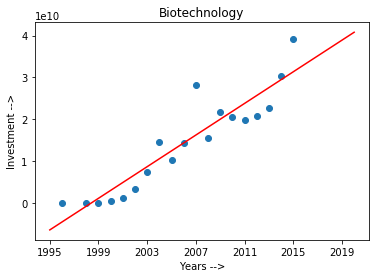

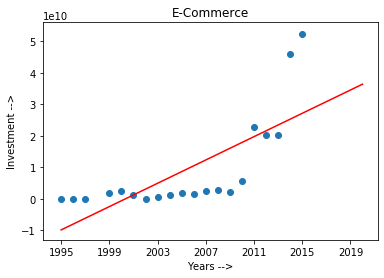

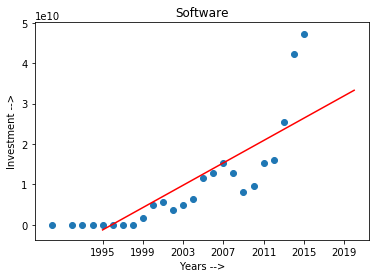

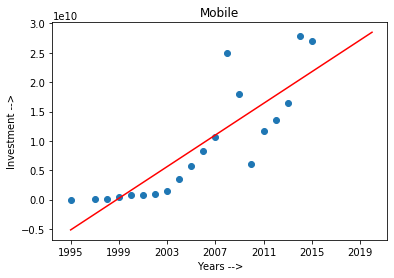

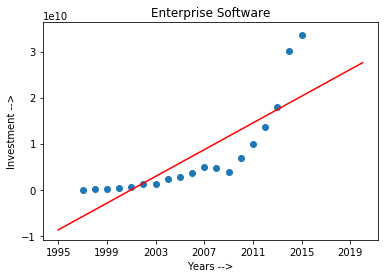

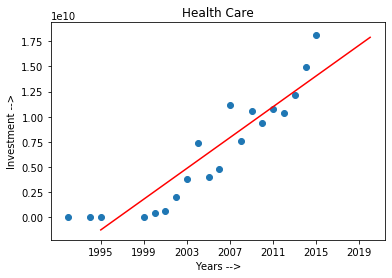

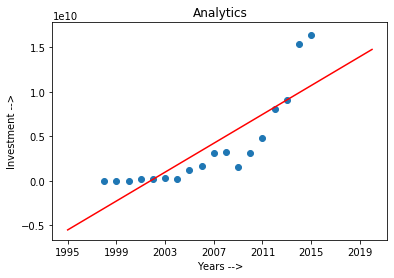

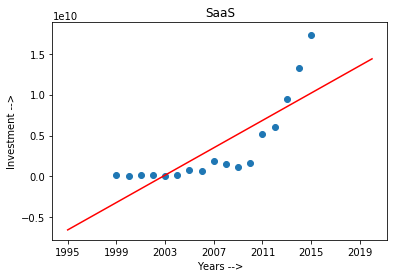

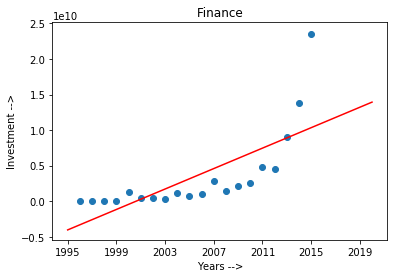

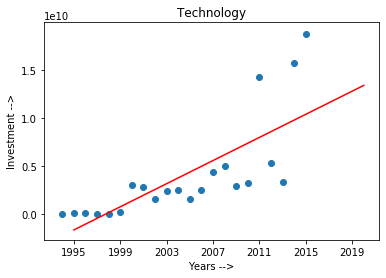

In [55]:
for category in topCategoriesPredicted:
    categoryDF=df2.filter(df2.CATEGORY == category)
    regressionTopPredictedCategoryDF=regressionTopPredictedDF.filter(regressionTopPredictedDF.CATEGORY == category)
    slope = [row.Slope for row in regressionTopPredictedCategoryDF.collect()][0]
    Intercept = [row.Intercept for row in regressionTopPredictedCategoryDF.collect()][0]
    #print(slope)
    x = [categoryDF.select('YEAR').collect()]
    y = [categoryDF.select('TOTAL_DEC').collect()] 
    
    Line = np.poly1d([slope, Intercept])
    xp = np.linspace(1995, 2020, 100)
    plt.plot(xp, Line(xp), c='r')
    
    plt.xticks(np.arange(1995, 2020, 4.0))
    plt.ylabel('Investment -->')  
    plt.xlabel('Years -->')  
    plt.title(category)
    
    plt.scatter(x, y)
    plotname = 'regression' + category + '.png'
    plt.savefig(plotname , pi=300, quality =95 )
    plt.show()